Stacked Model Cross-Validated Accuracy: 0.8069549934090766
Fitting 5 folds for each of 6 candidates, totalling 30 fits
RandomForest Model Average Cross-Validated Accuracy: 0.8226790534178645
Fitting 5 folds for each of 3 candidates, totalling 15 fits
LogisticRegression Model Average Cross-Validated Accuracy: 0.8237963718536188
Fitting 5 folds for each of 3 candidates, totalling 15 fits
KNeighbors Model Average Cross-Validated Accuracy: 0.81146820664114
Fitting 5 folds for each of 3 candidates, totalling 15 fits
DecisionTree Model Average Cross-Validated Accuracy: 0.8192768815516918
Fitting 5 folds for each of 4 candidates, totalling 20 fits
GradientBoosting Model Average Cross-Validated Accuracy: 0.8372732408511707
Fitting 5 folds for each of 12 candidates, totalling 60 fits
XGBoost Model Average Cross-Validated Accuracy: 0.8440085368150146
Fitting 5 folds for each of 9 candidates, totalling 45 fits
SVM Model Average Cross-Validated Accuracy: 0.832741196409516


C:\Users\idaya\PycharmProjects\pythonProject2\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\idaya\PycharmProjects\pythonProject2\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\idaya\PycharmProjects\pythonProject2\venv\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\idaya\PycharmProjects\pythonProject2\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed

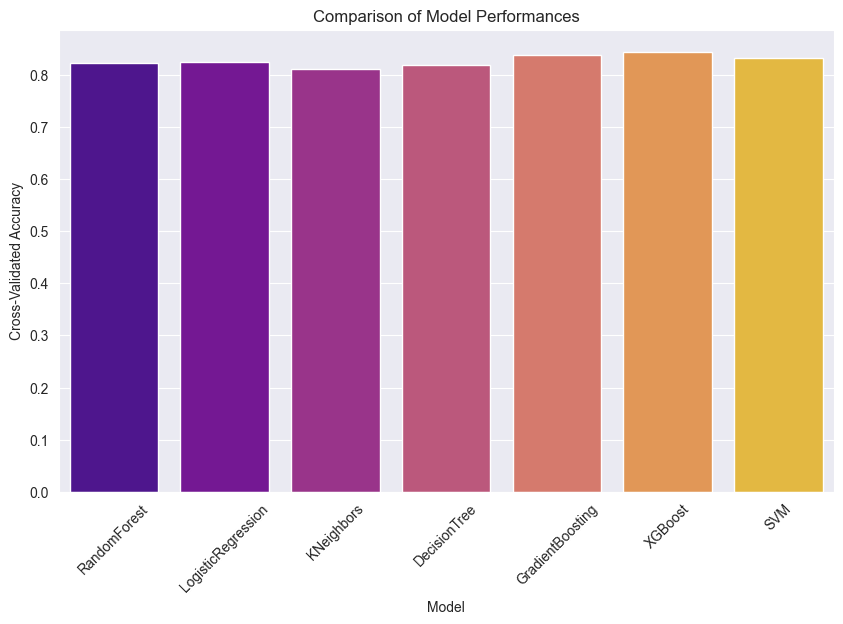

In [1]:
# This gave a score of 0.79665
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
train_data = pd.read_csv('train_Titanic.csv')
test_data = pd.read_csv('test_Titanic.csv')

# Feature Engineering
def feature_engineering(df):
    # Create new features
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    df['Title'] = df['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())
    common_titles = ['Mr', 'Mrs', 'Miss', 'Master', 'Ms']
    df['Title'] = df['Title'].apply(lambda title: title if title in common_titles else 'Other')
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    df.drop(['Cabin', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

train_data = feature_engineering(train_data)
test_data = feature_engineering(test_data)

# One-hot encode categorical variables
categorical_cols = ['Sex', 'Embarked', 'Title']
train_data = pd.get_dummies(train_data, columns=categorical_cols, drop_first=True)
test_data = pd.get_dummies(test_data, columns=categorical_cols, drop_first=True)

# Impute missing values
imputer = SimpleImputer(strategy='median')
numeric_cols = ['Age', 'Fare', 'Pclass', 'SibSp', 'Parch', 'FamilySize', 'IsAlone']
train_data[numeric_cols] = imputer.fit_transform(train_data[numeric_cols])
test_data[numeric_cols] = imputer.transform(test_data[numeric_cols])

# Ensure test data has the same columns as train data
test_data = test_data.reindex(columns=train_data.columns, fill_value=0)

 #Prepare training data
X_train = train_data.drop(['Survived', 'PassengerId'], axis=1)
y_train = train_data['Survived']

# Prepare test data
X_test = test_data.drop(['Survived', 'PassengerId'], axis=1)
# Define models and hyperparameters
models = {
    'RandomForest': {'model': RandomForestClassifier(), 'params': {'model__n_estimators': [100, 200], 'model__max_depth': [5, 10, None]}},
    'LogisticRegression': {'model': LogisticRegression(max_iter=1000), 'params': {'model__C': [0.1, 1, 10]}},
    'KNeighbors': {'model': KNeighborsClassifier(), 'params': {'model__n_neighbors': [3, 5, 7]}},
    'DecisionTree': {'model': DecisionTreeClassifier(), 'params': {'model__max_depth': [3, 5, 10]}},
    'GradientBoosting': {'model': GradientBoostingClassifier(), 'params': {'model__n_estimators': [100, 200], 'model__learning_rate': [0.05, 0.1]}},
    'XGBoost': {'model': XGBClassifier(), 'params': {'model__n_estimators': [100, 200], 'model__learning_rate': [0.05, 0.1], 'model__max_depth': [3, 5, 7]}}
}

models['SVM'] = {'model': SVC(), 'params': {'model__C': [0.1, 1, 10], 'model__gamma': [0.01, 0.1, 1]}}

# Ensemble Techniques - Basic Stacking
# Define base learners
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=5)),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('svm', SVC(C=1, gamma=0.1))
]

# Define meta-learner
meta_learner = GradientBoostingClassifier(n_estimators=50, learning_rate=0.05)

# Stacking Classifier
stacked_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)
# Training the stacked model
stacked_model.fit(X_train, y_train)

# Cross-validation to evaluate model performance
cv_scores = cross_val_score(stacked_model, X_train, y_train, cv=5)
print(f'Stacked Model Cross-Validated Accuracy: {np.mean(cv_scores)}')

# Model Evaluation
model_scores = {}
for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model['model'])
    ])
    grid_search = GridSearchCV(pipeline, model['params'], cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    # Corrected line: use a different variable name for the cross-validation scores
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)
    
    model_scores[name] = np.mean(cv_scores)
    print(f'{name} Model Average Cross-Validated Accuracy: {model_scores[name]}')

# Visualization of Model Performances
plt.figure(figsize=(10, 6))
sns.barplot(x=list(model_scores.keys()), y=list(model_scores.values()), palette="plasma")
plt.title('Comparison of Model Performances')
plt.xlabel('Model')
plt.ylabel('Cross-Validated Accuracy')
plt.xticks(rotation=45)
plt.show()

# Further steps for generating a submission file would go here
# Step 1: Select the Best Model
best_model_name = max(model_scores, key=model_scores.get)
best_model = models[best_model_name]['model']

# Step 2: Retrain on Full Training Data
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', best_model)
])
pipeline.fit(X_train, y_train)
# Step 3: Predict on Test Data
test_predictions = stacked_model.predict(X_test)

# Step 4: Create a Submission DataFrame
submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': test_predictions
})

# Step 5: Save DataFrame as CSV
submission.to_csv('submission.csv', index=False)